O risco de fraude é um tema sensível e de grande impacto, pois afeta diretamente tanto a vida financeira das pessoas quanto a sustentabilidade das operações da empresa. Fraudes geram perdas financeiras, aumentam custos operacionais e comprometem a confiança dos clientes. Com o apoio de modelos de previsão, é possível identificar padrões suspeitos com base em múltiplos fatores, permitindo prevenir danos ao cliente e reduzir significativamente o prejuízo da organização.

Neste estudo, utilizaremos um dataset disponível no Kaggle para realizar uma análise completa: exploraremos os dados, trataremos inconsistências, aplicaremos tuning dos algoritmos e utilizaremos Grid Search com validação cruzada para identificar o melhor modelo de detecção de fraude. Essa abordagem possibilita que a empresa implemente soluções mais precisas, eficientes e escaláveis no combate à fraude.

In [5]:
import pandas as pd
import numpy as np
import os

In [ ]:
import kagglehub

path = kagglehub.dataset_download("dhanushnarayananr/credit-card-fraud")
base = pd.read_csv(path+'\\card_transdata.csv')

In [ ]:
#Para salvar a base
base.to_csv('fraud_dataset.csv')

Ao observarmos a base, vemos algumas colunas que precisam ser escalonadas, e outras já binariamente classificadas, nenhuma feature classificadora como string.

In [4]:
base

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


Já é possível observar valores muito altos nos máximos em ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price'], e uma média de fraude de 8.7403%

In [97]:
base.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


Pelos quartis, vemos que a maioria dos valores das 3 primeiras colunas costumam ser 'pequenos' quando comparado ao valor máximo, com a média se encaixando entre 50 e 75% dos quartis

Vamos observar alguns detalhes com gráficos

In [ ]:
import plotly.express as px

grafico = px.scatter_matrix(base,dimensions=base.columns,color=base['fraud'])
grafico.show()

![alt text](analise_fraude_scatter.png)

No gráfico não é possível ver grupos bem definidos, então algoritmos de Clusterização podem não ser ideais para esta base

Podemos observar alguns outliers que se afastam muito da média, mas como são dados reais, iremos mantê-los

In [6]:
base.corr()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
distance_from_home,1.000000,0.000193,-0.001374,0.143124,-0.000697,-0.001622,-0.001301,0.187571
distance_from_last_transaction,0.000193,1.000000,0.001013,-0.000928,0.002055,-0.000899,0.000141,0.091917
ratio_to_median_purchase_price,-0.001374,0.001013,1.000000,0.001374,0.000587,0.000942,-0.000330,0.462305
repeat_retailer,0.143124,-0.000928,0.001374,1.000000,-0.001345,-0.000417,-0.000532,-0.001357
used_chip,-0.000697,0.002055,0.000587,-0.001345,1.000000,-0.001393,-0.000219,-0.060975
used_pin_number,-0.001622,-0.000899,0.000942,-0.000417,-0.001393,1.000000,-0.000291,-0.100293
online_order,-0.001301,0.000141,-0.000330,-0.000532,-0.000219,-0.000291,1.000000,0.191973
fraud,0.187571,0.091917,0.462305,-0.001357,-0.060975,-0.100293,0.191973,1.000000


Vemos uma forte correlação entre 'fraud' e 'ratio_to_median_purchase_price', e outras consideráveis, vamos observar as correlações maiores que 0.05 no código abaixo

In [22]:
array_corr = []

#Criando uma variável para o ambiente não recalcular toda vez que utilizarmos o dataframe na função
base_corr = base.corr()

for col in base_corr.columns:
    for line in base_corr.index:
        if abs(base_corr.at[col,line]) > 0.05 and abs(base_corr.at[col,line]) != 1.0:
            if [col, line, base_corr.at[col,line]] not in array_corr and\
                [line, col, base_corr.at[col,line]] not in array_corr:

                array_corr.append([col, line, base_corr.at[col,line]])

for each in array_corr:
    print(each[0])
    print(each[1])
    print(each[2])
    print('--------')


distance_from_home
repeat_retailer
0.14312425627726127
--------
distance_from_home
fraud
0.18757078277070352
--------
distance_from_last_transaction
fraud
0.09191691230926832
--------
ratio_to_median_purchase_price
fraud
0.46230472228826697
--------
used_chip
fraud
-0.060974597607915876
--------
used_pin_number
fraud
-0.10029253729161221
--------
online_order
fraud
0.19197252239629492
--------


Aqui vemos melhor as correlações, e que 'used_chip' (se usou cartão de crédito) e 'used_pin_number' (usou a senha), possuem uma correlação negativa em registros que foi registrado fraude.

In [20]:
base.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

A contagem entre fraude ou não está bem desabalanceada, podemos usar uma técnica de sobre ou sub amostragem para tentar obter um melhor resultado.

In [10]:
print(np.unique(base['fraud'], return_counts=True))

total = len(base.index)
print(str(np.unique(base['fraud'], return_counts=True)[1][0]/total *100)+"% Não Fraudes")
print(str(np.unique(base['fraud'], return_counts=True)[1][1]/total *100)+"% Fraudes")

(array([0., 1.]), array([912597,  87403]))
91.2597% Não Fraudes
8.7403% Fraudes


Vamos tratar os dados não normalizados.

In [7]:
from sklearn.preprocessing import StandardScaler

base_tratada = base.copy()

home_distance_scaler = StandardScaler()
home_scaled = home_distance_scaler.fit_transform(base.iloc[:,0].values.reshape(-1,1))
base_tratada['distance_from_home'] = home_scaled

distance_scaler = StandardScaler()
distance_scaled = home_distance_scaler.fit_transform(base.iloc[:,1].values.reshape(-1,1))
base_tratada['distance_from_last_transaction'] = home_scaled

ratio_median_scaler = StandardScaler()
ratio_median_scaled = ratio_median_scaler.fit_transform(base.iloc[:,2].values.reshape(-1,1))
base_tratada['ratio_to_median_purchase_price'] = ratio_median_scaled

#Vamos observar a base novamente
base_tratada.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1.000000e+06,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,8.355983e-18,8.355983e-18,-2.529532e-17,0.881536,0.350399,0.100608,0.650552,0.087403
std,1.000001e+00,1.000001e+00,1.000001e+00,0.323157,0.477095,0.300809,0.476796,0.282425
min,-4.071511e-01,-4.071511e-01,-6.500182e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.479205e-01,-3.479205e-01,-4.816812e-01,1.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.547919e-01,-2.547919e-01,-2.952096e-01,1.000000,0.000000,0.000000,1.000000,0.000000
75%,-1.353107e-02,-1.353107e-02,9.722443e-02,1.000000,1.000000,0.000000,1.000000,0.000000
max,1.621956e+02,1.621956e+02,9.500641e+01,1.000000,1.000000,1.000000,1.000000,1.000000


Os valores estão escalonados

In [ ]:
base_tratada

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.477882,0.477882,0.043491,1.0,1.0,0.0,0.0,0.0
1,-0.241607,-0.241607,-0.189300,1.0,0.0,0.0,0.0,0.0
2,-0.329369,-0.329369,-0.498812,1.0,0.0,0.0,1.0,0.0
3,-0.372854,-0.372854,-0.522048,1.0,1.0,0.0,1.0,0.0
4,0.268572,0.268572,0.142373,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,-0.373473,-0.373473,-0.070505,1.0,1.0,0.0,0.0,0.0
999996,-0.103318,-0.103318,0.340808,1.0,1.0,0.0,0.0,0.0
999997,-0.362650,-0.362650,-0.573694,1.0,1.0,0.0,1.0,0.0
999998,-0.342098,-0.342098,-0.481628,1.0,0.0,0.0,1.0,0.0


Separação de features e target, que neste estudo será a coluna indicadora de fraude

In [8]:
x = base_tratada.iloc[:,0:-1]
y = base_tratada.iloc[:,-1]

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 0, shuffle=True)

x_train.shape, x_test.shape

((900000, 7), (100000, 7))

Agora vamos encontrar os melhores valores para os algoritmos que iremos testar com a Cross Validation

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

#Especificação necessária para alguns algoritmos não retornarem um erro
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '2'

Criando esta função para não exibir erros de convergência, e já definindo como a função que irá nos retornar os melhores valores e precisão da validação cruzada

In [16]:
@ignore_warnings(category=ConvergenceWarning)
def grid_test(algoritmo, params, x, y):
    grid_search = GridSearchCV(estimator = algoritmo, param_grid = params, cv=5,scoring='accuracy')
    grid_search.fit(x, y)

    print(grid_search.best_params_)
    print(grid_search.best_score_)

Como temos 1m registros, iremos diminuir o tamanho da amostra para melhorar a performance do treino.

In [10]:
sample = base_tratada.sample(frac=0.05)
np.unique(sample['fraud'],return_counts=True)

total = len(base.index)

print("Base Original")
print(str(np.unique(base['fraud'], return_counts=True)[1][0]/total *100)+"% Não Fraudes")
print(str(np.unique(base['fraud'], return_counts=True)[1][1]/total *100)+"% Fraudes")

sample_total = len(sample.index)

print("Base de amostra")
print(str(np.unique(sample['fraud'], return_counts=True)[1][0]/sample_total *100)+"% Não Fraudes")
print(str(np.unique(sample['fraud'], return_counts=True)[1][1]/sample_total *100)+"% Fraudes")

Base Original
91.2597% Não Fraudes
8.7403% Fraudes
Base de amostra
91.216% Não Fraudes
8.784% Fraudes


A nossa amostra retirou a mesma taxa de fraudes, não resultando em um equilibrio das classes, ainda permitindo a análise com essa amostra

In [11]:
#Separando as novas variáveis para os testes
x_sample = sample.iloc[:,0:-1]
y_sample = sample.iloc[:,-1]

Cada célula irá representarum algoritmo que testaremos, muitas coisas são similares, só muda o algoritmo e parâmetros

In [ ]:
params = {
    'criterion':['gini','entropy'],
    'min_samples_split':[2,4,6],
    'min_samples_leaf':[1,2,3],
    'random_state':[0]
}

grid_test(DecisionTreeClassifier(),params,x_sample,y_sample)

{'criterion': 'gini', 'min_samples_leaf': 2, 'min_samples_split': 6, 'random_state': 0}
0.9926599999999999


In [14]:
params = {
    'n_estimators':[75,100,125],
    'criterion':['gini','entropy'],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2,3],
    'random_state':[0]
}

grid_test(RandomForestClassifier(),params,x_sample,y_sample)

{'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 75, 'random_state': 0}
0.99372


Usando esta técnica para não gerar erros de 'conversão não realizada, aumente o número de iterações', que polui demais o output

In [17]:
params = {
    'penalty':['l2'],
    'loss':['hinge', 'squared_hinge'],
    'C':[1.0,1.3,1.7,2.0,2.5,3,3.5,4],
    'max_iter':[500,1000,1500,2000,3000],
    'random_state':[0]
    }

grid_test(LinearSVC(),params,x_sample,y_sample)


{'C': 4, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 0}
0.95938


In [18]:
params = {
    'kernel':['rbf', 'sigmoid'],
    'gamma':['auto'],
    'C':[1.0,1.5,2.0],
    'tol':[0.005],
    'max_iter':[1000,1500,2000],
    'random_state':[0]
    }

grid_test(SVC(),params,x_sample,y_sample)

{'C': 2.0, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1500, 'random_state': 0, 'tol': 0.005}
0.98894


In [19]:
params = {
    'n_neighbors':[2,5,10,15],
    'weights':['uniform','distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size':[15,20,30,45,60],
    'p':[1.0,2.0],
    }

grid_test(KNeighborsClassifier(),params,x_sample,y_sample)

{'algorithm': 'auto', 'leaf_size': 15, 'n_neighbors': 2, 'p': 2.0, 'weights': 'uniform'}
0.9912399999999998


In [20]:
params = {
    'hidden_layer_sizes':[(4,4,4)],
    'activation':['tanh','relu'],
    'solver':['lbfgs','sgd'],
    'learning_rate':['adaptive'],
    'max_iter':[1000],
    'random_state':[0],
    }

grid_test(MLPClassifier(),params,x_sample,y_sample)

{'activation': 'tanh', 'hidden_layer_sizes': (4, 4, 4), 'learning_rate': 'adaptive', 'max_iter': 1000, 'random_state': 0, 'solver': 'lbfgs'}
0.99306


Vamos testar com um algoritmo de clusterizaação para ver os resultados

In [22]:
from sklearn.cluster import KMeans

params = {
    'n_clusters':[2,4,6,8,12,16],
    'init':['k-means++'],
    'max_iter':[5,10,20,50,150,300,500,1000],
    'tol':[0.005],
    'random_state':[0]
    }

grid_test(KMeans(),params,x_sample,y_sample)

{'init': 'k-means++', 'max_iter': 20, 'n_clusters': 2, 'random_state': 0, 'tol': 0.005}
0.48432000000000003


Vemos um resultado bem ruim, principalmente para este tipo de análise que involve uma decisão sensível.

Observando os resultados, o top 3 foi: DecisionTree, RandomForest, Rede Neural; iremos utilizar estes 3 para as próximas análises.

No código a seguir iremos realizar a validação cruzada para verificar, com os melhores parâmetros já tunados, qual será o melhor modelo, embaralhando a base e tirando a média da acurácia da bateria de testes, ainda trabalhando com a base reduzida de amostra para usar menos processamento.

In [ ]:
Dec_Tree = []
Rand_Fore = []
Neural = []

for i in range(30):

    kfold = KFold(n_splits=10, shuffle=True, random_state=i)


    dec_tree_model = DecisionTreeClassifier(criterion='gini', min_samples_leaf=2, min_samples_split=6)
    scores = cross_val_score(dec_tree_model, x_sample, y_sample, cv=kfold)
    Dec_Tree.append(scores.mean())

    rand_fore_model = RandomForestClassifier(criterion= 'entropy', min_samples_leaf= 3, min_samples_split= 2, n_estimators= 75, random_state= 0)
    scores = cross_val_score(rand_fore_model, x_sample, y_sample, cv=kfold)
    Rand_Fore.append(scores.mean())

    neural_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(4, 4, 4), learning_rate='adaptive', max_iter=1000, random_state=0, solver='lbfgs')
    scores = cross_val_score(neural_model, x_sample, y_sample, cv=kfold)
    Neural.append(scores.mean())

In [28]:
print("Média da Decision Tree: ",np.array(Dec_Tree).mean())
print("Média da Random Forest: ",np.array(Rand_Fore).mean())
print("Média da Rede Neural: ",np.array(Neural).mean())

Média da Decision Tree:  0.9925873333333333
Média da Random Forest:  0.9936439999999999
Média da Rede Neural:  0.992958


Na média, tivemos o Random Forest como melhor algoritmo por uma pequena margem, vamos treinar o modelo com este algoritmo, usando os dados escalonados

In [30]:
modelo = RandomForestClassifier(criterion= 'entropy', min_samples_leaf= 3, min_samples_split= 2, n_estimators= 75, random_state= 0)
modelo.fit(x_train,y_train)

,n_estimators,75
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
#Se quiser salvar o arquivo

import pickle

with open('datasets\\ModeloAnáliseFraude.pkl', 'wb') as file:
    pickle.dump(modelo, file)

In [ ]:
#Se quiser carregar o arquivo

import pickle

from sklearn.ensemble import RandomForestClassifier

with open('datasets\\ModeloAnáliseFraude.pkl', 'rb') as file:
    modelo = pickle.load(file)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

prev = modelo.predict(x_test)

In [11]:
accuracy_score(y_test, prev)

0.99413

Um Resultado muito bom! Vamos observar mais.

c:\Users\Juliano\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


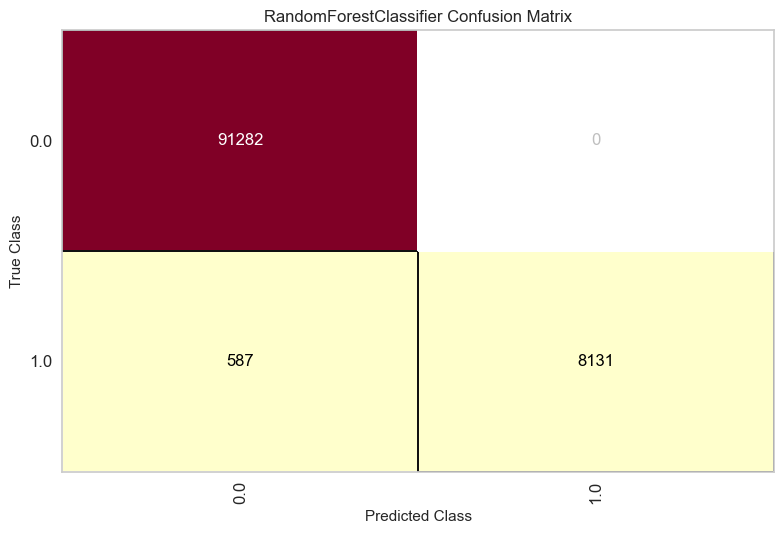

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [16]:
from yellowbrick.classifier import ConfusionMatrix as CM

matriz = CM(modelo)
matriz.fit(x_train, y_train)
matriz.score(x_test, y_test)
matriz.show()

Observando a matriz de confusão, vemos que temos casos de fraude marcados como não-fraude, e nenhum erro em casos de não-fraude, marcados como fraude

In [13]:
print(classification_report(y_test, prev))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     91282
         1.0       1.00      0.93      0.97      8718

    accuracy                           0.99    100000
   macro avg       1.00      0.97      0.98    100000
weighted avg       0.99      0.99      0.99    100000

